In [1]:
import multiprocessing as mp
import time
import numpy as np
import pandas as pd
from symmer.symplectic import random_PauliwordOp, PauliwordOp
from symmer.utils import random_symplectic_matrix, QubitOperator_to_dict


print("Number of processors: ", mp.cpu_count())

def runtime(func, obj, n_samples=10):
    samples = []
    for sample in range(n_samples):
        start = time.time()
        func(*obj)
        stop = time.time()
        samples.append(stop - start)
    return sum(samples)/n_samples

Number of processors:  8


In [7]:
def parallel_multiplication(P, Q):   
    # initiate a pool for parallel processing of Pauli multiplication
    pool = mp.Pool(mp.cpu_count())
    
    symp_stack = []
    coeff_stack = []
    
    def collect_result(result):
        phaseless_prod, coeff_vec = result
        symp_stack.append(phaseless_prod)
        coeff_stack.append(coeff_vec)
        
    # loop over the Pauli terms of right-hand PauliwordOp and parallelize
    for symp_vec, coeff, Y_count in zip(Q.symp_matrix, Q.coeff_vec, Q.Y_count):
        pool.apply_async(
            P._mul_symplectic, 
            args=(symp_vec, coeff, Y_count+P.Y_count), 
            callback=collect_result)
        
    # close the pool and let all the processes complete    
    pool.close()
    pool.join()  # postpones the execution of next line of code until all processes in the queue are done.
    
    return PauliwordOp(np.vstack(symp_stack), np.hstack(coeff_stack)).cleanup()

True

In [33]:
Y_symp = {'10q':[], '100q':[], '1000q':[]}
Y_para = {'10q':[], '100q':[], '1000q':[]}
Y_open = {'10q':[], '100q':[], '1000q':[]}
Y_qisk = {'10q':[], '100q':[], '1000q':[]}

for n_q in [10,100,1000]:
    print(n_q)
    key = f'{n_q}q'
    for n_t in range(1, 50):
        if n_t%10==0:
            print(n_t)

        P_symr = random_PauliwordOp(n_q, n_t)
        Q_symr = random_PauliwordOp(n_q, n_t)
        P_open = sum(P_symr.PauliwordOp_to_OF)
        Q_open = sum(Q_symr.PauliwordOp_to_OF)
        P_qisk = P_symr.to_PauliSumOp
        Q_qisk = Q_symr.to_PauliSumOp

        # check matching OpenFermion:
        if PauliwordOp(QubitOperator_to_dict(P_open*Q_open, n_q)) != P_symr*Q_symr:
            print('uh-oh')
        else:
            Y_symp[key].append(runtime(lambda x,y:x*y,(P_symr,Q_symr), n_samples=1))
            Y_para[key].append(runtime(parallel_multiplication,(P_symr,Q_symr), n_samples=1))
            Y_open[key].append(runtime(lambda x,y:x*y,(P_open,Q_open), n_samples=1))
            Y_qisk[key].append(runtime(lambda x,y:x@y,(P_qisk,Q_qisk), n_samples=1))

10
10
20
30
40
100
10
20
30
40
1000
10
20
30
40


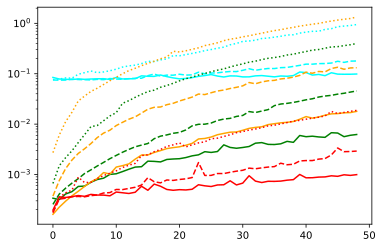

In [37]:
from matplotlib import pyplot as plt

lines = {'10q':'-', '100q':'--', '1000q':':'}

for n_q in ['10q', '100q', '1000q']:
    plt.plot(Y_symp[n_q], color='green', label='Symmer', ls = lines[n_q])
    plt.plot(Y_para[n_q], color='cyan', label='Symmer parallelized', ls = lines[n_q])
    plt.plot(Y_open[n_q], color='orange', label='OpenFermion', ls = lines[n_q])
    plt.plot(Y_qisk[n_q], color='red', label='Qiskit', ls = lines[n_q])

plt.yscale('log')
#plt.legend()

In [1]:
def mult(P,Q):
    a = np.einsum('ij->i', (P.X_block+Q.X_block)*P.Z_block)
    b = np.einsum('ij->i', (P.Z_block+Q.Z_block)*Q.X_block)
    c = np.einsum('ij->i', np.bitwise_and(
            (np.bitwise_xor(P.X_block, Q.X_block)), np.bitwise_xor(P.Z_block, Q.Z_block))
        )
    # a,b combines the Y counts of P,Q plus a further sign flip
    # c tracks the Y count of the output Paulis
    prod = (1j)**(a+b+3*c)
    
    return PauliwordOp(np.bitwise_xor(P.symp_matrix, Q.symp_matrix), P.coeff_vec*Q.coeff_vec*prod)

%timeit mult(P,Q)

NameError: name 'P' is not defined

In [ ]:
for i in range(100):

    P = random_PauliwordOp(10,1)
    P.coeff_vec = [1]
    Q = random_PauliwordOp(10,1)
    Q.coeff_vec = [1]
    PQ = P*Q

    
    a = (P.X_block+Q.X_block).dot(P.Z_block.T)
    b = (P.Z_block+Q.Z_block).dot(Q.X_block.T)
    c = (np.bitwise_xor(P.X_block, Q.X_block)).dot(np.bitwise_xor(P.Z_block, Q.Z_block).T)
    
    prod= (1j)**(a+b+3*c)
    
    comp = prod[0]
    targ = PQ.coeff_vec
    print(comp, targ, comp == targ)
    print()